## In this notebook, we will be learning about semantic search using FAISS and embedding libraries like sentence transformers

In [1]:
!pip install sentence-transformers
!pip install faiss-cpu

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 44.9 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 6.8 MB 44.0 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=5892123223e42c0d85f43fbd1135dc416f67518a2e79a862cf498987c30674cb
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 8.6 MB 4.9 MB/s 


## Downloading data

Source: https://github.com/jamescalam/data.git

In [2]:
!git clone https://github.com/jamescalam/data.git

Cloning into 'data'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 134 (delta 3), reused 133 (delta 2), pack-reused 0
Receiving objects: 100% (134/134), 79.25 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import time
import seaborn as sns
import gc

## Loading sentences

In [4]:
with open("/content/data/sentence_embeddings_15K/sentences.txt", "r") as f:
    sentences = f.readlines()
sentences = [sentence.strip() for sentence in sentences]

## Loading embeddings

In [5]:
word_embeddings = []
for i in range(57):
    word_embeddings.append(np.load(f"/content/data/sentence_embeddings_15K/embeddings_{i}.npy"))

sentence_embeddings = np.vstack(word_embeddings)

In [6]:
print(f"Number of sentences {len(sentences)}")
print(f"Shape of embeddings {sentence_embeddings.shape}")

Number of sentences 14504
Shape of embeddings (14504, 768)


## Loading sentence encoder

In [7]:
encoder = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## IndexFlatL2

In [8]:
# Creating a flat index. Index requires the embedding dimension
# For FlatL2, it is a exhaustive search and therefore does not require any training 
index =faiss.IndexFlatL2(768)
print(f"Model is trained: {index.is_trained}")

Model is trained: True


In [9]:
## Adding embeddings into the index
index.add(sentence_embeddings)
print(f"Total item in index {index.ntotal}")

Total item in index 14504


### Querying the index
1. Encode the query

In [10]:
query_vector = encoder.encode(['someone sprints with a football'])

k = 4 #k nearest
start = time.time()
D, I = index.search(query_vector,k)
end = time.time()

print(f"Query took {end-start:.5f}s")
print("Results")
for i,d in zip(I[0],D[0]):
    print(sentences[i], f"[distance: {d}]")

Query took 0.01751s
Results
A group of football players is running in the field [distance: 54.623748779296875]
A group of people playing football is running in the field [distance: 54.8535270690918]
Two groups of people are playing football [distance: 57.35625457763672]
A person playing football is running past an official carrying a football [distance: 57.90589904785156]


## Plotting the vector size against time
We can see that FlatL2 increases linearly with the number of vectors

In [11]:
num_vectors = [250000, 500000, 750000,1000000]
time_taken = []
k=5
query_vector = encoder.encode(['someone sprints with a football'])

for num_vector in num_vectors:
    random_vectors = np.random.randn(num_vector, 768).astype(np.float32)
    index = faiss.IndexFlatL2(768)
    index.add(random_vectors)
    start = time.time()
    D, I = index.search(query_vector, k)
    end = time.time()
    time_taken.append(end-start)
    del random_vectors
    del index
    gc.collect()
    

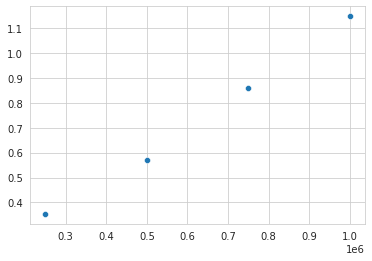

In [12]:
sns.set_style("whitegrid")
plot = sns.scatterplot(x=num_vectors, y=time_taken)

## Voronoi cell (IVFFlat)
1. First create a flat index (quantizer)
2. We need to decide the number of Voronoi cell (nlist)
3. train the index with the embeddings
4. add the embeddings

We can see that the search is extremely fast (20 times faster)
### **We can use index.nprobe = 10 to increase the number of cells to search to 10

In [13]:
n_list = 50
quantizer = faiss.IndexFlatL2(768)
index = faiss.IndexIVFFlat(quantizer, 768, n_list)
index.train(sentence_embeddings)
print(f"Model is trained: {index.is_trained}")

Model is trained: True


In [25]:
num_vectors = [250000, 500000, 750000,1000000]
time_taken = []
n_list = 50
k=5
query_vector = encoder.encode(['someone sprints with a football'])

for num_vector in num_vectors:
    random_vectors = np.random.randn(num_vector, 768).astype(np.float32)
    quantizer = faiss.IndexFlatL2(768)
    index = faiss.IndexIVFFlat(quantizer, 768, n_list)
    index.train(random_vectors)
    index.add(random_vectors)
    start = time.time()
    D, I = index.search(query_vector, k)
    end = time.time()
    time_taken.append(end-start)
    del random_vectors
    del index
    gc.collect()

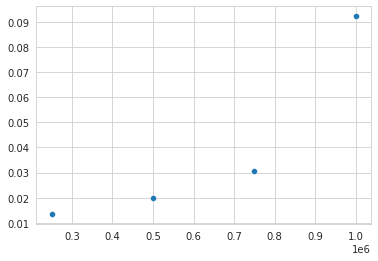

In [26]:
sns.set_style("whitegrid")
plot = sns.scatterplot(x=num_vectors, y=time_taken)

## IVF with product quantization

1. define subvector/ bits of centroid/ cells
2. define quantizer Flat2L
3. define indexIVFPQ 
4. train with the embeddings 
5. add the embeddings into the index

We can see that the IVFsearch is even faster with product quantization

In [22]:
m=8 #subvector 
bits =8 # centoid bits
n_list=50
quantizer = faiss.IndexFlatL2(768)
index = faiss.IndexIVFPQ(quantizer, 768, n_list, m, bits)
index.train(sentence_embeddings)
index.add(sentence_embeddings)

In [27]:
num_vectors = [250000, 500000, 750000,1000000]
time_taken = []
n_list = 50
k=5
m=8 #subvector 
bits =8 # centoid bits

query_vector = encoder.encode(['someone sprints with a football'])

for num_vector in num_vectors:
    random_vectors = np.random.randn(num_vector, 768).astype(np.float32)
    quantizer = faiss.IndexFlatL2(768)
    index = faiss.IndexIVFPQ(quantizer, 768, n_list, m, bits)
    index.train(random_vectors)
    index.add(random_vectors)
    start = time.time()
    D, I = index.search(query_vector, k)
    end = time.time()
    time_taken.append(end-start)
    del random_vectors
    del index
    gc.collect()

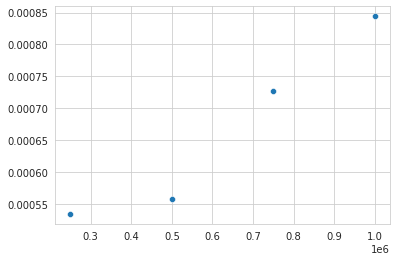

In [29]:
sns.set_style("whitegrid")
plot = sns.scatterplot(x=num_vectors, y=time_taken)